# 1. Penjelasan Dataset

## 1.1 Kasus yang Diambil
Dataset yang digunakan adalah "Sentiment Analysis for Mental Health". Tujuan dari proyek ini adalah untuk membangun model Machine Learning yang dapat mengklasifikasikan sebuah teks ke dalam status yang terkait dengan kesehatan mental, seperti 'Normal','Anxiety', 'Depression', 'Suicidal',','Bipolar','Stress' dan 'Personality Disorder'.

## 1.2 Penjelasan Kolom
* **statement**:  Kolom ini berisi teks postingan yang akan dianalisis. Ini akan menjadi fitur (X).
* **status**:  Kolom ini berisi label status untuk setiap statement. Ini adalah target (y)

In [1]:
# --- 1.3 Import Library ---
print("Mengimpor semua library...")

# Untuk data tabel
import pandas as pd
import numpy as np

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

# Untuk Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download modul NLTK 
nltk.download('punkt')
nltk.download('stopwords')

# Untuk Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Mengatur agar plot muncul di notebook
%matplotlib inline

print("Library siap.")

Mengimpor semua library...
Library siap.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# --- 1.4 Load Data ---

nama_file = "Combined Data.csv" 
kolom_teks = "statement"  
kolom_label = "status"

# Muat data
try:
    df = pd.read_csv(nama_file, encoding='latin-1')
except Exception as e:
    print(f"Error: {e}. Mencoba encoding lain...")
    df = pd.read_csv(nama_file, encoding='utf-8')

print("Data berhasil dimuat. 5 baris pertama:")
print(df.head())

print("\nInfo Dataset:")
df.info()

Data berhasil dimuat. 5 baris pertama:
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [3]:
# --- SEL 1.5 : Memfilter Dataset Menjadi 3 Label ---

# TENTUKAN 3 LABEL 
labels_to_keep = ['Normal', 'Depression', 'Anxiety']

print(f"Jumlah data SEBELUM difilter: {len(df)}")
print(f"Distribusi data LAMA:\n{df[kolom_label].value_counts()}")

# Lakukan proses filtering
# Ini akan menyimpan SEMUA baris yang labelnya ada di daftar 'labels_to_keep'
df = df[df[kolom_label].isin(labels_to_keep)]

print("\n--- Filter Selesai ---")
print(f"Jumlah data SETELAH difilter: {len(df)}")

# (Penting) Reset index setelah memfilter
df.reset_index(drop=True, inplace=True)

print(f"Distribusi data BARU (3 Label):\n{df[kolom_label].value_counts()}")

Jumlah data SEBELUM difilter: 53043
Distribusi data LAMA:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

--- Filter Selesai ---
Jumlah data SETELAH difilter: 35643
Distribusi data BARU (3 Label):
status
Normal        16351
Depression    15404
Anxiety        3888
Name: count, dtype: int64


In [4]:
# --- 2. Cek Data Kosong dan Duplikat ---

print(f"Jumlah data SEBELUM dibersihkan: {len(df)}")

# 1. Cek data kosong (NaN)
print(f"\nJumlah data kosong di tiap kolom:\n{df.isnull().sum()}")

# 2. Hapus baris yang punya NaN di kolom teks atau label
df.dropna(subset=[kolom_teks, kolom_label], inplace=True)

# 3. Cek data duplikat
print(f"\nJumlah data duplikat: {df.duplicated().sum()}")
# Opsional: Hapus duplikat jika ada
df.drop_duplicates(inplace=True)

# 4. Reset index setelah menghapus data
df.reset_index(drop=True, inplace=True)

print(f"\nJumlah data SETELAH dibersihkan (dari NaN & Duplikat): {len(df)}")

Jumlah data SEBELUM dibersihkan: 35643

Jumlah data kosong di tiap kolom:
Unnamed: 0     0
statement     55
status         0
dtype: int64

Jumlah data duplikat: 0

Jumlah data SETELAH dibersihkan (dari NaN & Duplikat): 35588


Distribusi data label:
status
Normal        16343
Depression    15404
Anxiety        3841
Name: count, dtype: int64


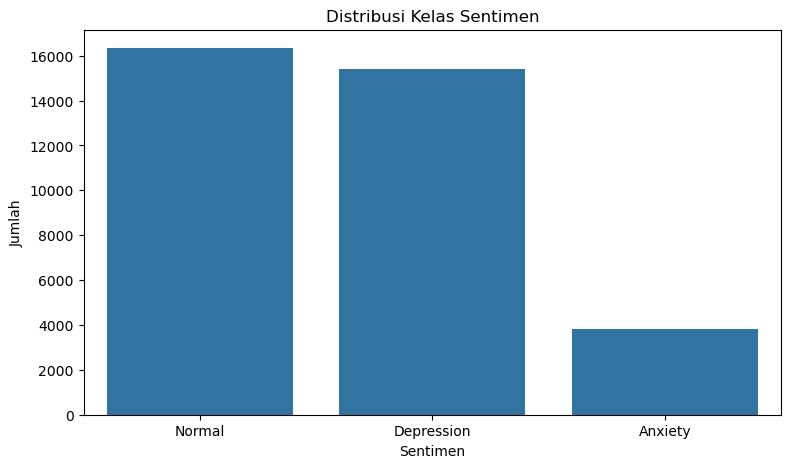

In [5]:
# --- 2. Distribusi Data Label ---

print("Distribusi data label:")
print(df[kolom_label].value_counts())

# Visualisasikan
plt.figure(figsize=(9, 5))
sns.countplot(x=kolom_label, data=df, order=df[kolom_label].value_counts().index)
plt.title('Distribusi Kelas Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [6]:
# --- 3. Text Processing: Definisi Fungsi ---

# Tentukan stopwords 
stop_words = set(stopwords.words('english'))

def bersihkan_teks(text):
    # 1. Cek jika bukan string (mengatasi NaN/float)
    if not isinstance(text, str):
        text = "" 
    
    # 2. Case Folding (Normalisasi)
    text = text.lower()
    
    # 3. Hapus Tanda Baca, Angka, Simbol (Normalisasi)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 4. Tokenisasi
    tokens = word_tokenize(text)
    
    # 5. Stopword Removal
    kata_bersih = [kata for kata in tokens if kata not in stop_words]
    
    # 6. Gabungkan kembali
    return ' '.join(kata_bersih)

# Tes fungsi
print(f"Contoh Teks Bersih: {bersihkan_teks('I am feeling REALLY anxious 100%!!')}")

Contoh Teks Bersih: feeling really anxious


In [7]:
# --- 3. Terapkan Fungsi ke Dataframe ---

print("Memulai preprocessing seluruh data... (Mungkin butuh waktu)")
df['text_clean'] = df[kolom_teks].apply(bersihkan_teks)
print("Preprocessing selesai.")

# Tampilkan hasilnya
df[[kolom_teks, 'text_clean']].head()

Memulai preprocessing seluruh data... (Mungkin butuh waktu)
Preprocessing selesai.


,statement,text_clean
0,oh my gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,ive shifted focus something else im still worried
4,"I'm restless and restless, it's been a month n...",im restless restless month boy mean


Membuat Word Cloud...


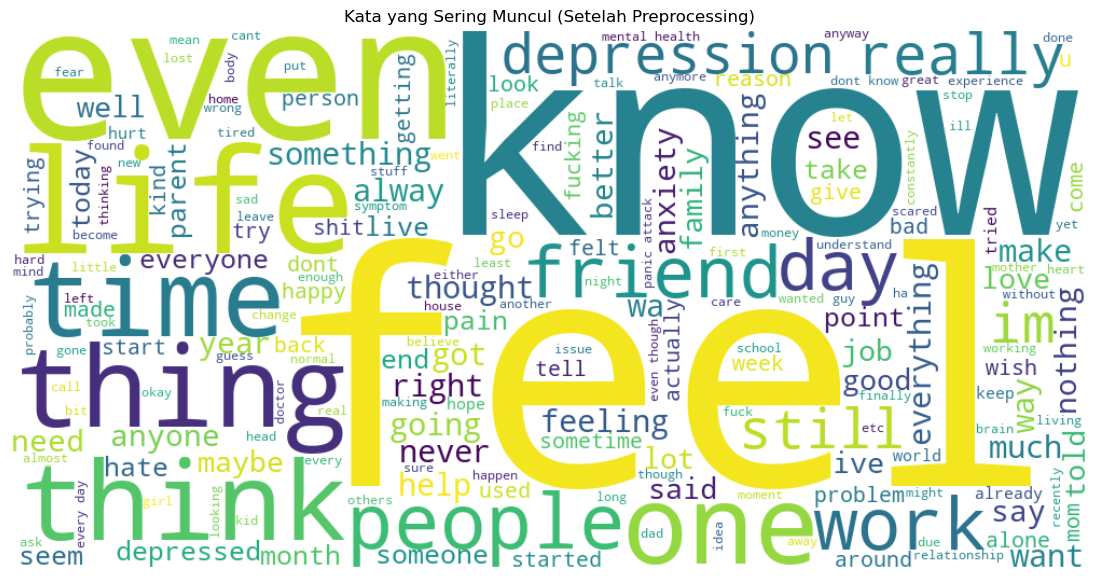

In [8]:
# ---  Word Cloud Teks Bersih ---

print("Membuat Word Cloud...")
all_text = ' '.join(df['text_clean'])

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata yang Sering Muncul (Setelah Preprocessing)')
plt.show()

In [9]:
# --- 3. Text Vektorisasi (TF-IDF) ---

# 1. Definisikan X (fitur) dan y (target)
X = df['text_clean']
y = df[kolom_label] 

print("Mengecek 5 data y (label) teratas:")
print(y.head())

# 2. Buat "cetakan" TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.65)

# 3. Ubah teks X menjadi angka (matriks TF-IDF)
X_tfidf = vectorizer.fit_transform(X)

print("\nBentuk matriks X_tfidf (angka):", X_tfidf.shape)

Mengecek 5 data y (label) teratas:
0    Anxiety
1    Anxiety
2    Anxiety
3    Anxiety
4    Anxiety
Name: status, dtype: object

Bentuk matriks X_tfidf (angka): (35588, 52361)


In [10]:
# --- 3. Data Splitting ---

# Skala 80% data latihan, 20% data tes
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(f"Ukuran data Latihan (X_train): {X_train.shape}")
print(f"Ukuran data Ujian (X_test): {X_test.shape}")

Ukuran data Latihan (X_train): (28470, 52361)
Ukuran data Ujian (X_test): (7118, 52361)


# 4. Data Modeling

Model yang dipilih adalah **Support Vector Machine**. 
Adalah algoritma machine learning yang diawasi yang mengklasifikasikan data dengan menemukan garis optimal atau hyperplane yang memaksimalkan jarak antara setiap kelas dalam ruang N-dimensi.
Alasan pemilihan model:
SVM adalah pilihan standar industri untuk klasifikasi teks karena cepat, efisien di ribuan fitur, dan sangat efektif dalam menemukan "batas" terbaik di antara kelas-kelas yang rumit.

In [11]:
# --- 4. Melatih Model (MENGGUNAKAN LinearSVC) ---

# 1. Buat "objek" modelnya
# Kita ganti LogisticRegression dengan LinearSVC
model = LinearSVC(random_state=42, max_iter=2000, C=0.40) 

print("Mulai melatih model (dengan data SMOTE dan LinearSVC)...")

# 2. Latih dengan data SMOTE (resampled)
model.fit(X_train, y_train)

print("Model selesai dilatih!")

Mulai melatih model (dengan data SMOTE dan LinearSVC)...
Model selesai dilatih!


Akurasi Model: 93.38%

--- Classification Report ---
              precision    recall  f1-score   support

     Anxiety       0.91      0.81      0.85       715
  Depression       0.95      0.93      0.94      3135
      Normal       0.92      0.97      0.94      3268

    accuracy                           0.93      7118
   macro avg       0.93      0.90      0.91      7118
weighted avg       0.93      0.93      0.93      7118

--- Confusion Matrix ---


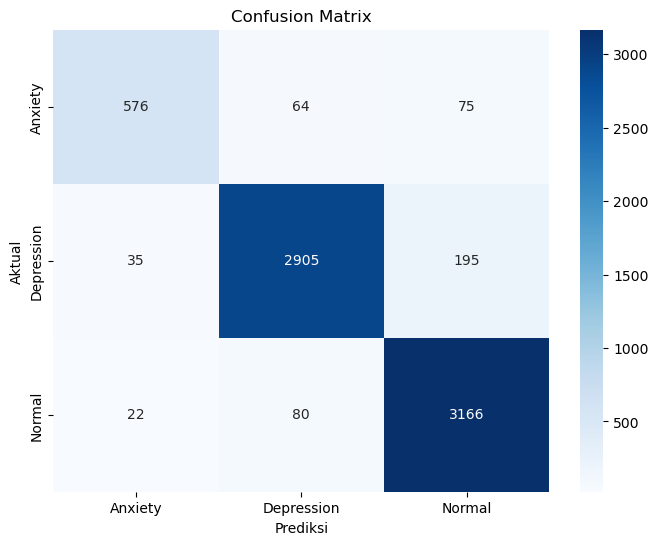

In [12]:
# --- 5. Data Evaluasi ---

# 1. Suruh model menebak data X_test (soal ujian)
y_pred = model.predict(X_test)

# 2. Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%\n")

# 3. Tampilkan Laporan Klasifikasi (Precision, Recall, F1-Score)
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 4. Tampilkan Confusion Matrix
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# --- 6. Data Prediksi ---

print("Membuat prediksi pada data baru...")

# 1. Buat beberapa data baru yang relevan dengan label 
data_baru = [

    "Everything feels pointless and empty. I just want to be alone.",      
    "I'm feeling pretty good today, just a regular day."
]

# 2. Bersihkan data baru
data_baru_bersih = [bersihkan_teks(teks) for teks in data_baru]

# 3. Ubah jadi angka (HANYA .transform())
data_baru_tfidf = vectorizer.transform(data_baru_bersih)

# 4. Prediksi!
prediksi_baru = model.predict(data_baru_tfidf)

# 5. Tampilkan hasil
print("\n--- Hasil Prediksi Data Baru ---")
for teks, sentimen in zip(data_baru, prediksi_baru):
    print(f"\nTeks: '{teks}'\nPrediksi Label: -> {sentimen.upper()} <-")

Membuat prediksi pada data baru...

--- Hasil Prediksi Data Baru ---

Teks: 'Everything feels pointless and empty. I just want to be alone.'
Prediksi Label: -> DEPRESSION <-

Teks: 'I'm feeling pretty good today, just a regular day.'
Prediksi Label: -> NORMAL <-
